In [2]:
import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 5


In [3]:
def convert(tree, training_vars):
    array = tree.arrays()    
    df = pd.DataFrame(array, columns=training_vars)

    #feature = tree2array(tree,
    #                    branches = ['dRmm','dEtamm','dPhimm','M_jj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
    #                               ,'dRmin_mmj','dRmax_mmj','dPhijj','leadingJet_pt','subleadingJet_pt',
    #                               'leadingJet_eta','subleadingJet_eta','cthetaCS','Higgs_mass','Higgs_pt','Higgs_eta' ],
    #                    selection = 'dRmm>-9000.')

    return df

In [297]:
training_vars = [b'leading_photon_pt', b'leading_photon_eta', b'leading_photon_phi', 
                 b'subleading_photon_pt', b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt', b'subleading_bjet_eta', b'subleading_bjet_phi']

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

SIGNAL_FILE='/bigdata/shared/idutta/VBFHToMuMu.root'
BKG_FILE='/bigdata/shared/idutta/DYJetsToLL.root'

path = '/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'
paths = ["job_1_ntuple0625v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8.root", 
         "job_2_ntuple0625v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8.root", 
         "job_3_ntuple0625v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8.root", 
         "job_4_ntuple0625v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8.root", 
         "job_5_ntuple0625v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8.root", 
         "job_6_ntuple0625v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root", 
         "job_7_ntuple0625v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root", 
         "job_8_ntuple0625v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-Sherpa.root", 
         "job_9_ntuple0625v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-Sherpa.root", 
         "job_10_ntuple0625v1/DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root"]
names = ['GluGluToHH signal', 'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHToGG',
         'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox2B', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox' ]
i = 2 # select sample

SIGNAL_FILE = uproot.open(path + 'job_1_ntuple0625v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8.root')
BKG_FILE = uproot.open(path + paths[i])
    
sigtree = SIGNAL_FILE['tree']
bkgtree = BKG_FILE['tree']

sig_frame_all = convert(sigtree, training_vars + aug_vars + w_var)
bkg_frame_all = convert(bkgtree, training_vars + aug_vars + w_var)

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][training_vars]

sig_df = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][training_vars + w_var]
bkg_df = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][training_vars + w_var]

sig_weight = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][w_var]
bkg_weight = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [7]:
sig_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'genweight'
1,145.241119,0.918335,0.491089,75.707062,0.319824,1.547607,142.2500,2.209473,-2.042480,28.140625,0.004900,-0.789917,0.074707,0.050354,0.125061,0.000139
5,81.548317,-0.114059,2.528809,68.587204,-0.079712,0.564209,80.1250,-1.288086,-0.381775,60.750000,-1.138916,-2.197266,0.039551,0.964844,1.004395,-0.000139
7,109.037231,-0.835327,1.176514,87.997322,-0.765747,2.546875,115.9375,-1.357910,-1.699951,69.312500,-0.727295,-0.625854,0.331299,0.424072,0.755371,0.000139
9,99.698898,-0.390930,-0.474426,54.716755,-0.526611,1.511963,92.5625,0.323792,2.379883,26.750000,2.041504,-3.094238,0.189087,0.656250,0.845337,0.000139
10,78.673645,2.106934,-1.360596,74.914726,1.376465,0.152924,178.5000,1.395996,2.549316,31.062500,1.725098,0.694458,0.998047,0.077209,1.075256,0.000139


In [32]:
bkg_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'genweight'
3,93.258316,-0.445679,-0.661499,54.095470,0.255127,1.121338,94.56250,0.055000,2.435059,29.796875,-0.229980,-2.079590,0.027069,0.019806,0.046875,0.005102
8,57.269352,-0.940918,1.135742,53.408329,0.114944,-2.228516,52.59375,0.481323,2.708984,47.406250,0.730957,0.092072,0.078003,0.116699,0.194702,-0.005102
13,68.204269,0.344421,0.865967,59.091099,1.168701,-1.290283,62.50000,1.907959,2.461426,31.812500,1.946533,-1.197998,0.469482,0.063416,0.532898,0.005102
19,58.905148,2.123535,2.710938,49.445988,0.998047,-0.537231,54.75000,0.608398,1.497803,39.593750,0.372986,-1.265625,0.010712,0.011497,0.022209,-0.005102
28,81.474594,-0.485718,-0.095688,25.573645,1.260254,-2.102051,100.87500,-0.560425,2.686523,27.187500,1.390137,-0.176849,0.037994,0.029480,0.067474,-0.005102


In [298]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
#from skopt import gp_minimize

In [299]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]

TRAIN: [     0      1      2 ... 249237 249239 249240] TEST: [     3     13     14 ... 249229 249231 249238]
TRAIN: [     0      1      2 ... 249238 249239 249240] TEST: [     5      7     22 ... 249217 249220 249228]
TRAIN: [     0      1      2 ... 249238 249239 249240] TEST: [     6      9     10 ... 249223 249226 249236]
TRAIN: [     2      3      4 ... 249237 249238 249240] TEST: [     0      1      8 ... 249232 249233 249239]
TRAIN: [     0      1      3 ... 249236 249238 249239] TEST: [     2      4     15 ... 249235 249237 249240]


In [300]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
model = Sequential()
model.add(Dense(100, input_dim=len(training_vars),activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

(199393, 12)
(199393,)
(49848, 12)
(49848,)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 100)               1300      
_________________________________________________________________
dropout_82 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_83 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 64)                6464      
_________________________________________________________________
dropout_84 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_113

In [247]:
print(x_train)
print(y_train)

[[ 0.3610708   1.2840298  -0.8495912  ... -0.89761573 -1.6323949
   0.4989945 ]
 [ 6.948768    0.86235166 -0.59673834 ...  2.6870046   0.94080704
   1.0893383 ]
 [ 3.3818126   0.45990035 -1.2815145  ...  1.7093809   1.6503487
   1.0481057 ]
 ...
 [-0.8775229   1.7184633  -1.1571076  ... -0.36449638 -1.180396
  -1.4448336 ]
 [-0.8292901  -0.33665493 -0.76975    ... -0.6932295   1.3545827
  -0.8064078 ]
 [-0.24841638  0.37511453  0.65702397 ...  0.5259416   1.6429267
  -1.041189  ]]
[1. 1. 1. ... 0. 0. 0.]


In [74]:
#print X_train, y_train
#print X_val, y_val
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [301]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
1064/1064 [==============================] - 2s 2ms/step - loss: 0.5033 - accuracy: 0.7665 - val_loss: 0.2460 - val_accuracy: 0.9466
Epoch 2/50
1064/1064 [==============================] - 2s 2ms/step - loss: 0.4714 - accuracy: 0.7778 - val_loss: 0.2330 - val_accuracy: 0.9511
Epoch 3/50
1064/1064 [==============================] - 2s 2ms/step - loss: 0.4659 - accuracy: 0.7820 - val_loss: 0.2498 - val_accuracy: 0.9432
Epoch 4/50
1064/1064 [==============================] - 2s 2ms/step - loss: 0.4603 - accuracy: 0.7839 - val_loss: 0.2250 - val_accuracy: 0.9436
Epoch 5/50
1064/1064 [==============================] - 2s 2ms/step - loss: 0.4571 - accuracy: 0.7858 - val_loss: 0.2510 - val_accuracy: 0.9340
Epoch 6/50
1064/1064 [==============================] - 2s 2ms/step - loss: 0.4531 - accuracy: 0.7875 - val_loss: 0.2435 - val_accuracy: 0.9518
Epoch 7/50
1064/1064 [==============================] - 2s 2ms/step - loss: 0.4492 - accuracy: 0.7884 - val_loss: 0.2287 - val_accuracy:

In [12]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

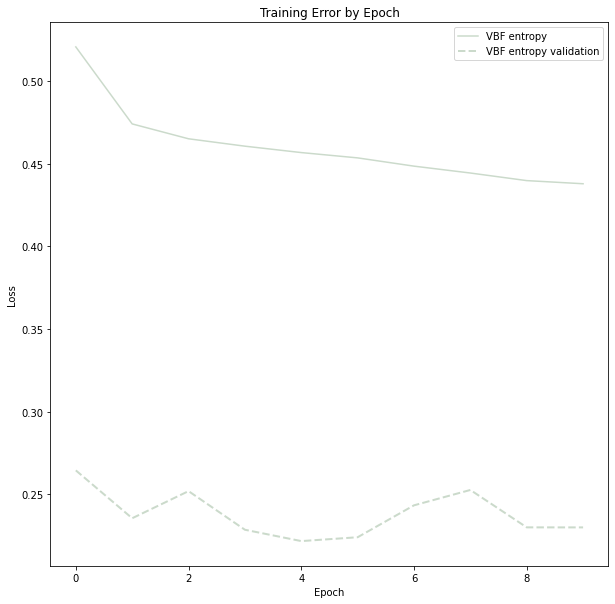

In [45]:
show_losses( [("VBF entropy", hist)])

In [302]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [303]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

(49848,)
(49848,)
(49848, 12)


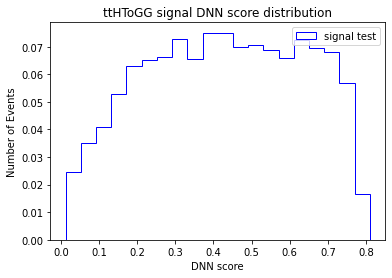

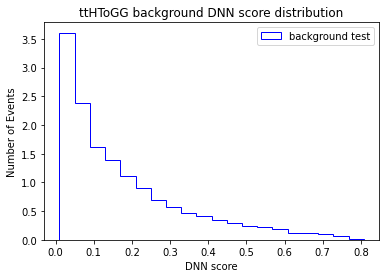

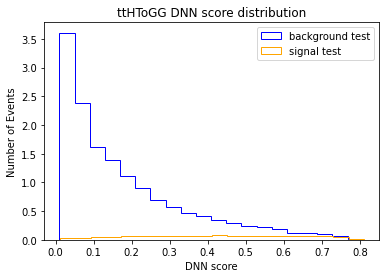

In [304]:
# Plot DNN score distribution
print(y_pred.shape)
print(y_test.shape)
print(x_test.shape)
bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title(names[i] + ' signal DNN score distribution')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/DNN_Score_Plts/{names[i]}_sig_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title(names[i] + ' background DNN score distribution')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/DNN_Score_Plts/{names[i]}_bkg_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.hist(sgl, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title(names[i] + ' DNN score distribution')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/DNN_Score_Plts/{names[i]}_score.png', format='png')
plt.show()

In [269]:
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k, i):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}')
    file.write(f'original test background: {np.sum(bgd_weight)}')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}')
    file.write(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    file.close()
    return re_sig / np.sqrt(re_sig + re_bkg)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


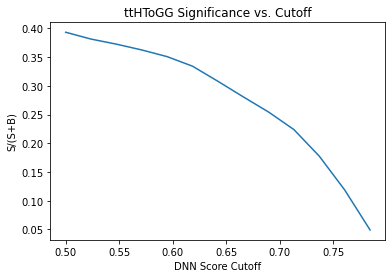

In [305]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/' + names[i]+'_DNN_score.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()

plt.plot(test_sc, sc_vals, label = names[i])
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/(S+B)')
plt.title(names[i] + ' Significance vs. Cutoff')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/DNN_Score_Plts/{names[i]}_significance.png', format='png')
plt.show()

In [200]:
significance(0.778)

TypeError: significance() missing 1 required positional argument: 'i'

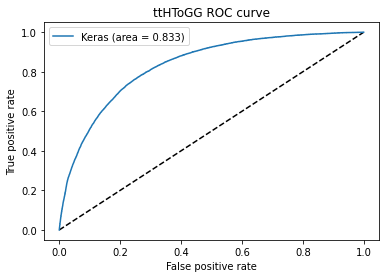

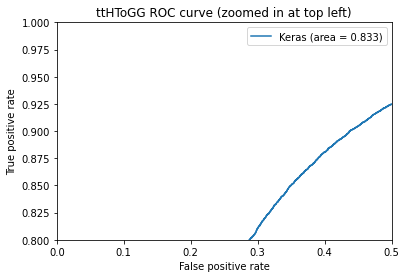

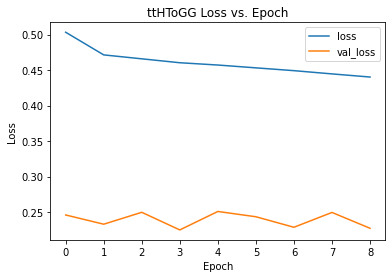

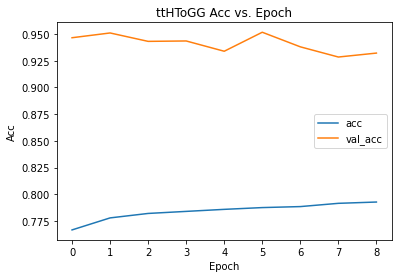

In [306]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(names[i] + ' ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/ROC_Plts/{names[i]}_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(names[i] + ' ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/ROC_Plts/{names[i]}_ROC_curve_zoom')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(names[i] + ' Loss vs. Epoch')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/Epoch_Plts/{names[i]}_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title(names[i] + ' Acc vs. Epoch')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/Epoch_Plts/{names[i]}_acc_epoch.png', format='png')
plt.show()

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


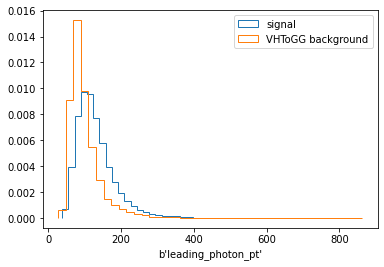

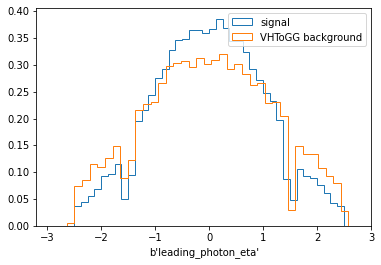

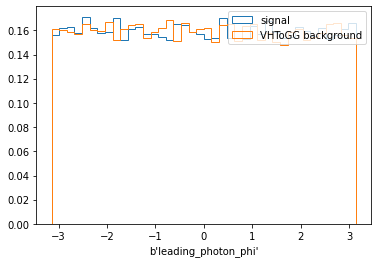

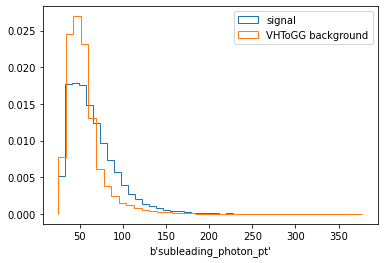

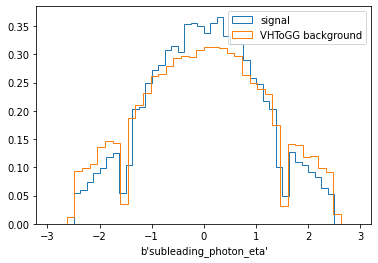

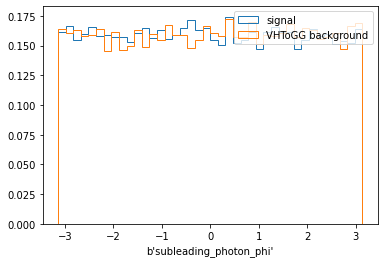

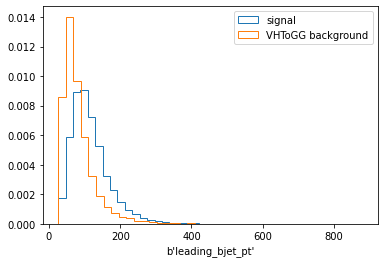

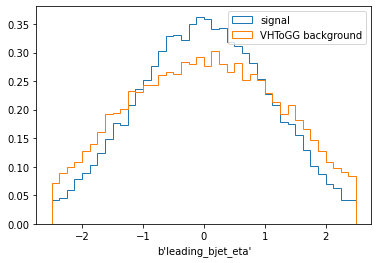

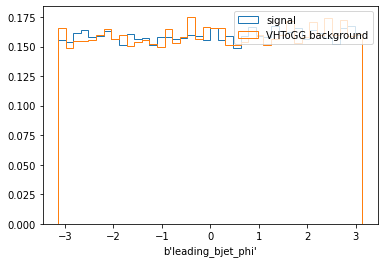

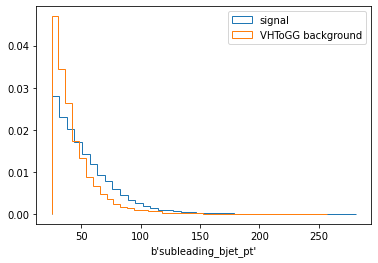

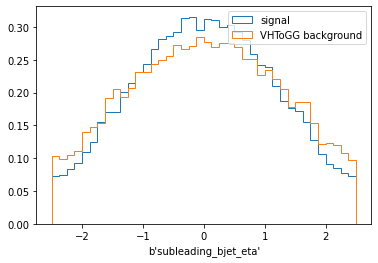

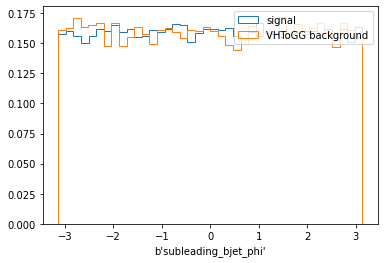

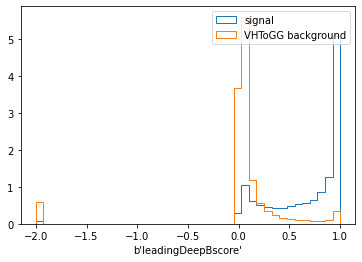

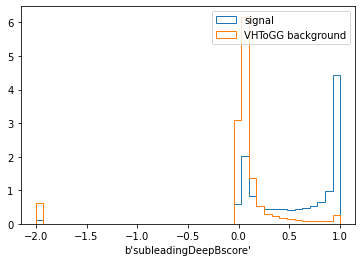

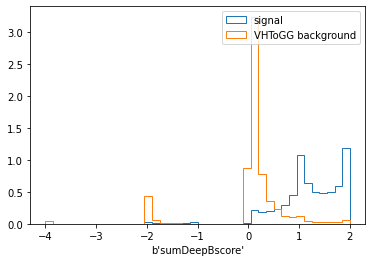

In [33]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= names[i] + ' background')
    plt.xlabel(hlf)
    plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/BackgroundVsSignal_Plts/{names[i]}_{hlf}')
    plt.legend(loc='best')

# 